In [8]:
# !pip install textblob # (처음 실행시 필요)

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   --- ----------------------------------- 61.4/626.3 kB 825.8 kB/s eta 0:00:01
   ---------------------------------- ----- 542.7/626.3 kB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 5.7 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob # 설치 필요 -> !pip install textblob
import nltk
import chardet

%matplotlib inline

# nltk 데이터 다운로드 (첫 실행 시 필요)
nltk.download('vader_lexicon')

# nltk 데이터 다운로드 (첫 실행 시 필요)
nltk.download('stopwords')

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

raw = pd.read_csv('../data/Paris/reviews.csv') # 저는 따로 파일두고 작업해서 path 수정했습니다.
df = raw.copy()

df = df[['listing_id','date','comments']]

df = df.rename(columns= {
    'listing_id' : '숙소_id',
    'date': '리뷰날짜',
    'comments' : '리뷰'
})

# 리뷰 결측치 제거
df = df[~df['리뷰'].isnull()]

# 리뷰 내의 <br> 제거
df['리뷰'] = df['리뷰'].str.replace('<br>\s*', ' ', regex=True)
df['리뷰'] = df['리뷰'].str.replace('<br/>\s*', ' ', regex=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# import nltk

# # nltk 데이터 다운로드 (첫 실행 시 필요)
# nltk.download('vader_lexicon')

# # nltk 데이터 다운로드 (첫 실행 시 필요)
# nltk.download('stopwords')

In [12]:
df.shape

(1793899, 3)

In [13]:
df.head()

,숙소_id,리뷰날짜,리뷰
0,39948,2013-09-20,Aliyah et Philippe m'ont réservé un accueil ex...
1,39948,2013-09-29,Aliyah and Philippe are gracious hosts and eve...
2,3109,2017-10-28,Tout s'est bien déroulé. Merci bien. PG
3,3109,2017-11-03,Un petit nid fouiller douillet situé dans app...
4,3109,2018-07-24,"Appartement spacieux, propre,clair, et calme à..."


### sample 2만개 무작위 추출

In [15]:
sample_df = df.sample(n=20000, random_state=42)
sample_df.head()

,숙소_id,리뷰날짜,리뷰
635135,16111334,2017-06-06,"It's small place, perfect for one person, Juan..."
876778,25372146,2018-07-16,A great host. Easy to get too and great for in...
1596014,736692003338033524,2022-12-31,This place is exactly as described. It has bee...
1178606,39887301,2023-05-13,5*
1482117,604943910199552860,2023-02-10,Très bien


영어 리뷰와 영어가 아닌 리뷰 분리

In [19]:
# !pip install langdetect

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
      ------------------------------------ 20.5/981.5 kB 330.3 kB/s eta 0:00:03
     - ----------------------------------- 41.0/981.5 kB 487.6 kB/s eta 0:00:02
     -------------- ----------------------- 368.6/981.5 kB 2.9 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 5.6 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 5.6 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993253 sha256=bb468175717b0a6248b7d8bfee117179d9c78b55ecee90164743d38383c3dac9
  Stored in directory: c:\users\rladn\appdata\local\pip\cache\wheels\0a\f2\b2\e5ca405801e05eb7c8ed5b3b4bcf1f

In [20]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Seed를 설정하여 결과의 재현성을 확보
DetectorFactory.seed = 0

# 리뷰 데이터를 영어와 영어가 아닌 데이터로 분리하는 함수
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# 영어로 적힌 리뷰와 영어가 아닌 리뷰로 분리
sample_df['is_english'] = sample_df['리뷰'].apply(is_english)
english_reviews = sample_df[sample_df['is_english'] == True]
non_english_reviews = sample_df[sample_df['is_english'] == False]

# 결과 확인
print(f"영어 리뷰 개수: {english_reviews.shape[0]}")
print(f"영어가 아닌 리뷰 개수: {non_english_reviews.shape[0]}")

영어 리뷰 개수: 11185
영어가 아닌 리뷰 개수: 8815


In [22]:
non_english_reviews.head()

,숙소_id,리뷰날짜,리뷰,is_english
1178606,39887301,2023-05-13,5*,False
1482117,604943910199552860,2023-02-10,Très bien,False
367721,6746882,2022-02-12,"Nous avons passé un excellent séjour, la local...",False
921014,26953855,2018-08-17,Rien à redire! Je recommande chaudement cet ap...,False
859467,24511658,2019-06-23,"Studio très agréable, espace optimisé à son ma...",False


In [29]:
non_english_reviews['리뷰']

1178606                                                   5*
1482117                                            Très bien
367721     Nous avons passé un excellent séjour, la local...
921014     Rien à redire! Je recommande chaudement cet ap...
859467     Studio très agréable, espace optimisé à son ma...
                                 ...                        
1263227    Die Unterkunft würde ich bei jeder Paris Reise...
365954     Le studio d'Amélie est conforme au descriptif....
135235     La habitación es tal cual se muestra en las im...
1056501                                     Buen alojamiento
370015     Esta en buena ubicación la casa hay total libe...
Name: 리뷰, Length: 8815, dtype: object

구글 translation api 사용하여 샘플 리뷰 영어로 변환 (처음 샘플링 할 때만 사용)
 - 이유 : 크래딧 사용 최소화를 위해

In [16]:
# !pip install google-cloud-translate==2.0.1

Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ---------------------------------------- 0.0/90.9 kB ? eta -:--:--
   ---------------------------------------- 90.9/90.9 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/120.4 kB ? eta -:--:--
   ---------------------------------------- 120.4/120.4 kB ? eta 0:00:00
   ---------------------------------------- 0.0/152.9 kB ? eta -:--:--
   --------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [26]:
import os

# 이 경로는 실제 JSON 키 파일의 위치에 맞게 수정해야 합니다.
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/Paris/mulcam-translation-api-2be39ee1960a.json"

In [27]:
from google.cloud import translate_v2 as translate

translate_client = translate.Client()

def translate_to_english(text):
    # 타겟 언어는 'en'으로 설정합니다.
    result = translate_client.translate(text, target_language='en')
    return result['translatedText']

In [30]:
# 주의: 이 과정은 비용이 많이 들고 시간이 오래 걸릴 수 있습니다.
non_english_reviews['translated_review'] = non_english_reviews['리뷰'].apply(translate_to_english)

C:\Users\rladn\AppData\Local\Temp\ipykernel_11324\2955057302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_reviews['translated_review'] = non_english_reviews['리뷰'].apply(translate_to_english)


In [31]:
# 번역된 리뷰를 '리뷰' 컬럼에 저장
non_english_reviews['리뷰'] = non_english_reviews['translated_review']

# 필요 없는 컬럼 제거
non_english_reviews.drop(['is_english', 'translated_review'], axis=1, inplace=True)
english_reviews.drop(['is_english'], axis=1, inplace=True)

# 데이터 합치기
combined_reviews = pd.concat([english_reviews, non_english_reviews], ignore_index=True)

C:\Users\rladn\AppData\Local\Temp\ipykernel_11324\3244173923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_reviews['리뷰'] = non_english_reviews['translated_review']
C:\Users\rladn\AppData\Local\Temp\ipykernel_11324\3244173923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_english_reviews.drop(['is_english', 'translated_review'], axis=1, inplace=True)
C:\Users\rladn\AppData\Local\Temp\ipykernel_11324\3244173923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

In [32]:
combined_reviews

,숙소_id,리뷰날짜,리뷰
0,16111334,2017-06-06,"It's small place, perfect for one person, Juan..."
1,25372146,2018-07-16,A great host. Easy to get too and great for in...
2,736692003338033524,2022-12-31,This place is exactly as described. It has bee...
3,46506548,2022-07-05,This place was fantastic ! The location was pe...
4,16584190,2019-05-23,Anne's apartment was an excellent base for our...
...,...,...,...
19995,44200125,2023-07-30,I would book this accommodation again on every...
19996,6838781,2022-11-18,Amélie&#39;s studio conforms to the descriptio...
19997,1487718,2023-10-21,"The room is as shown in the images, it is smal..."
19998,34090374,2019-06-15,Good accommodation


영어 변환 후 다시 전처리 한번 더  진행 (혹시몰라서)

In [34]:
import nltk

# NLTK 데이터 다운로드
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...


True

In [35]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# NLTK 데이터 다운로드
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# 1. 데이터 정제
# 중복 제거
combined_reviews.drop_duplicates(subset=['리뷰'], inplace=True)

# 결측값 처리
combined_reviews.dropna(subset=['리뷰'], inplace=True)

# 2. 텍스트 전처리
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 구두점 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    return text

combined_reviews['processed_review'] = combined_reviews['리뷰'].apply(preprocess_text)

# 3. 데이터 분석
# >> 단어 빈도수 확인
from collections import Counter

all_words = ' '.join(combined_reviews['processed_review']).split()
word_freq = Counter(all_words)

# 상위 10개의 단어 출력
print(word_freq.most_common(10))

# 예: 감정 분석
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

combined_reviews['sentiment'] = combined_reviews['processed_review'].apply(analyze_sentiment)

# 감정 분석 결과 요약
sentiment_summary = combined_reviews['sentiment'].value_counts()
print(sentiment_summary)

# 결과 저장 (예: CSV 파일로 저장) - 처음 샘플링 때만 사용
# combined_reviews.to_csv("processed_reviews.csv", index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rladn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('the', 50542), ('and', 41300), ('a', 29992), ('to', 24102), ('is', 20966), ('very', 19188), ('wa', 17566), ('in', 16959), ('apartment', 12858), ('we', 11813)]
sentiment
positive    19123
negative      328
neutral       283
Name: count, dtype: int64


단어 빈도수 시각화

C:\Users\rladn\AppData\Local\Temp\ipykernel_11324\1058729888.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequencies, y=words, palette="Blues_d")


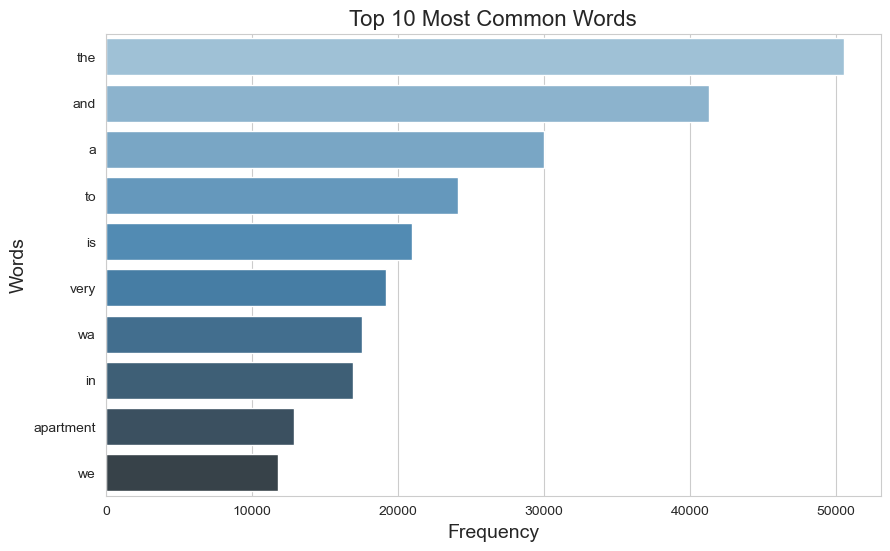

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 10개 단어와 그 빈도수 추출
top_words = word_freq.most_common(10)
words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]

# seaborn 스타일 설정
sns.set_style("whitegrid")

# 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x=frequencies, y=words, palette="Blues_d")

# 그래프 제목 및 라벨 설정
plt.title('Top 10 Most Common Words', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)

# 그래프 보여주기
plt.show()

??? 시각화 전에 잘못한듯...
 - 단어 빈도 수 결과 확인하니 불용어 제거가 제대로 안 된듯

여기서는 구글 api로 번역하는 부분이 오래 걸리므로 저장한 csv 파일을 바탕으로 01-2로 넘어감